In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split
import torchvision.transforms as transforms
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import random

# Load Dataset

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("dnyaneshwalwadkar/fingerprintdata-npz")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/fingerprintdata-npz


(6000, 90, 90, 1) (6000, 4)


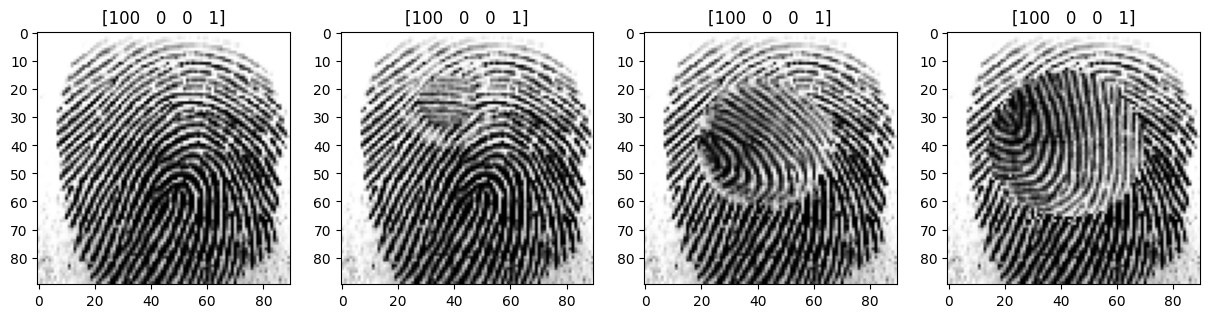

In [ ]:
x_real = np.load(path+'/dataset/x_real.npz')['data']
y_real = np.load(path+'/dataset/y_real.npy')
x_easy = np.load(path+'/dataset/x_easy.npz')['data']
y_easy = np.load(path+'/dataset/y_easy.npy')
x_medium = np.load(path+'/dataset/x_medium.npz')['data']
y_medium = np.load(path+'/dataset/y_medium.npy')
x_hard = np.load(path+'/dataset/x_hard.npz')['data']
y_hard = np.load(path+'/dataset/y_hard.npy')

print(x_real.shape, y_real.shape)

plt.figure(figsize=(15, 10))
plt.subplot(1, 4, 1)
plt.title(y_real[0])
plt.imshow(x_real[0].squeeze(), cmap='gray')
plt.subplot(1, 4, 2)
plt.title(y_easy[0])
plt.imshow(x_easy[0].squeeze(), cmap='gray')
plt.subplot(1, 4, 3)
plt.title(y_medium[0])
plt.imshow(x_medium[0].squeeze(), cmap='gray')
plt.subplot(1, 4, 4)
plt.title(y_hard[0])
plt.imshow(x_hard[0].squeeze(), cmap='gray')

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.is_available()

True

# Train Test Split

In [ ]:
x_data = np.concatenate([x_easy, x_medium, x_hard], axis=0)
label_data_ = np.concatenate([y_easy, y_medium, y_hard], axis=0)

print(label_data_[:,0])#subject_id(1-600)

unique_values = np.unique(label_data_[:, 0])
print(unique_values)


label_data= label_data_[:,0] -1
print(np.unique(label_data))#subject_id(0-599)

x_train, x_temp, label_train, label_temp = train_test_split(x_data, label_data, test_size=0.2,shuffle=True,random_state=41)
x_val, x_test, label_val, label_test = train_test_split(x_temp, label_temp, test_size=0.5,shuffle=True,random_state=41)

print(x_data.shape, label_data.shape)
print(x_train.shape, label_train.shape)
print(x_val.shape, label_val.shape)
print(x_test.shape, label_test.shape)


[100 100 100 ...   9   9   9]
[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216
 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234
 235 236 237 238 239 

# Data Generator

In [ ]:
from torchvision.models import efficientnet_b4, EfficientNet_B4_Weights
import torchvision.transforms.functional as F

weights = EfficientNet_B4_Weights.DEFAULT



In [ ]:
pre_trans = weights.transforms()
pre_trans

ImageClassification(
    crop_size=[380]
    resize_size=[384]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [ ]:
class MyDataset(Dataset):
    def __init__(self, x_data, label_data):
        self.x_data = x_data  # Expect shape (N, 90, 90, 1)
        self.label_data = label_data

    def __getitem__(self, idx):
        image = F.to_pil_image(self.x_data[idx].squeeze())
        image = image.convert('RGB')
        image = pre_trans(image).to(device)
        label = torch.tensor(self.label_data[idx], dtype=torch.long).to(device)
        return image, label

    def __len__(self):
        return len(self.x_data)

In [ ]:
# Create instances of MyDataset for training and validation
train_data = MyDataset(x_train, label_train)
val_data = MyDataset(x_val, label_val)
test_data = MyDataset(x_test, label_test)
# Create DataLoader for training data
BATCH_SIZE = 32
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)
train_N = len(train_loader.dataset)
valid_N = len(val_loader.dataset)
test_N = len(test_loader.dataset)
# Example usage
for batch_x, batch_y in train_loader:
    print(batch_x.shape, batch_y.shape)  # Print shapes of a batch
    break

torch.Size([32, 3, 380, 380]) torch.Size([32])


# Loading Model

In [ ]:
model = efficientnet_b4(weights=weights)
N_CLASSES = 600
for param in model.features.parameters():
    param.requires_grad = False
for param in model.features[8:].parameters():
    param.requires_grad = True
model.classifier = nn.Sequential(
    nn.Linear(model.classifier[1].in_features, 1024),
    nn.BatchNorm1d(1024),
    nn.ReLU(),
    nn.Dropout(p=0.4),
    nn.Linear(1024, N_CLASSES)
)
model.to(device)

Downloading: "https://download.pytorch.org/models/efficientnet_b4_rwightman-23ab8bcd.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b4_rwightman-23ab8bcd.pth
100%|██████████| 74.5M/74.5M [00:00<00:00, 177MB/s]


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
            (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActiv

In [ ]:
from torchsummary import summary
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 48, 112, 112]           1,296
       BatchNorm2d-2         [-1, 48, 112, 112]              96
              SiLU-3         [-1, 48, 112, 112]               0
            Conv2d-4         [-1, 48, 112, 112]             432
       BatchNorm2d-5         [-1, 48, 112, 112]              96
              SiLU-6         [-1, 48, 112, 112]               0
 AdaptiveAvgPool2d-7             [-1, 48, 1, 1]               0
            Conv2d-8             [-1, 12, 1, 1]             588
              SiLU-9             [-1, 12, 1, 1]               0
           Conv2d-10             [-1, 48, 1, 1]             624
          Sigmoid-11             [-1, 48, 1, 1]               0
SqueezeExcitation-12         [-1, 48, 112, 112]               0
           Conv2d-13         [-1, 24, 112, 112]           1,152
      BatchNorm2d-14         [-1, 24, 1

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
model.load_state_dict(torch.load('/content/eff_model.pth2'))

<All keys matched successfully>

# Confusion Matrix

In [ ]:

import torch.nn.functional as F_nn
from torchvision.transforms.functional import to_pil_image



class MyDataset(Dataset):
    def __init__(self, x_data, label_data):
        self.x_data = x_data
        self.label_data = label_data

    def __getitem__(self, idx):

        image = to_pil_image(self.x_data[idx].squeeze())
        image = image.convert('RGB')
        image = pre_trans(image).to(device)
        label = torch.tensor(self.label_data[idx], dtype=torch.long).to(device)
        return image, label

    def __len__(self):
        return len(self.x_data)

def predict(model, test_loader, device):
    model.eval()
    all_preds = []
    all_probs = []
    all_targets = []
    test_images = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            outputs = model(images)


            probs = F_nn.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
            all_targets.extend(labels.cpu().numpy())
            test_images.extend(images.cpu().numpy())

    return all_preds, all_probs, all_targets, test_images

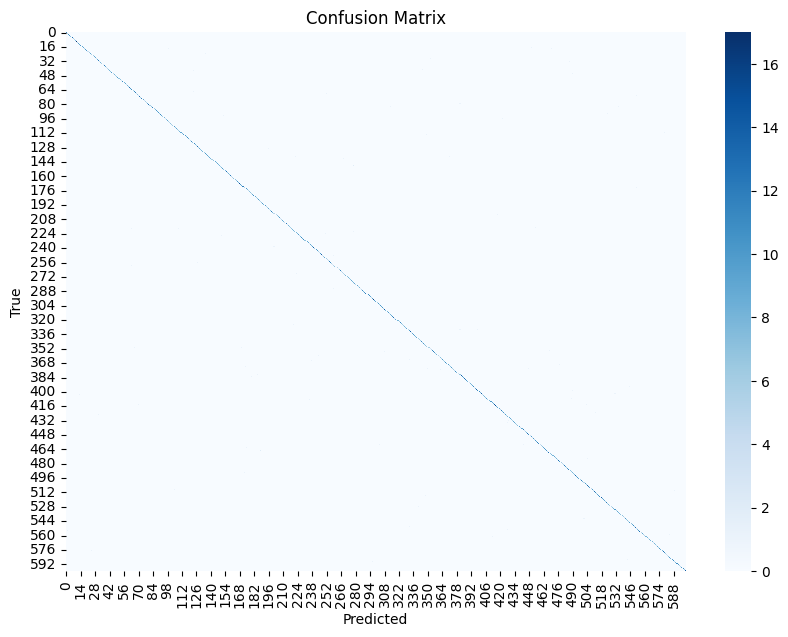

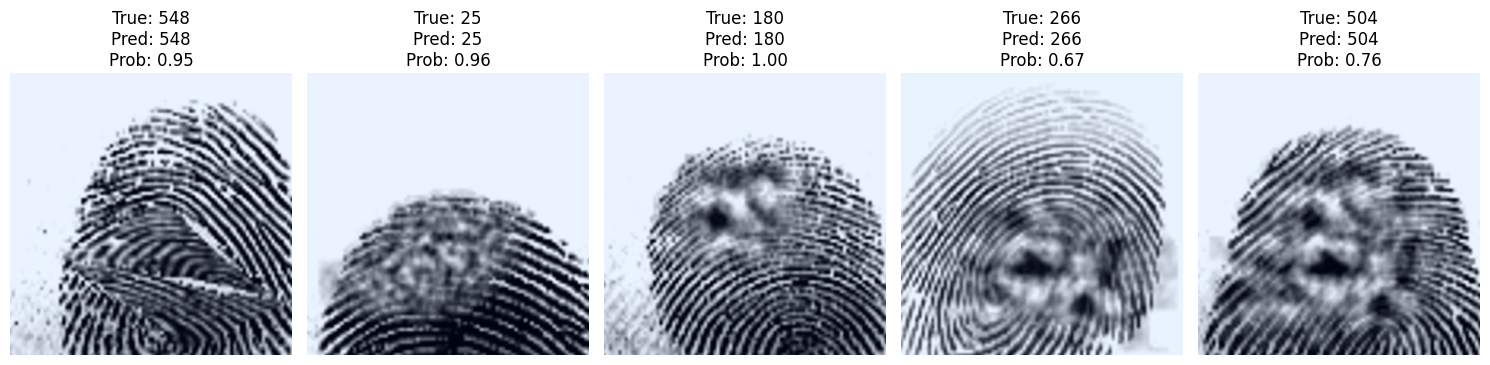

In [ ]:
import torch.nn.functional as F
from torchvision.transforms.functional import to_pil_image
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from torch.utils.data import DataLoader

test_data = MyDataset(x_test, label_test)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)



predictions, probabilities, true_labels, sample_images = predict(model, test_loader, device)


#print("\nClassification Report:")
#print(classification_report(true_labels, predictions))


cm = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=False, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


confused_pairs = []
for true_cls in range(cm.shape[0]):
    for pred_cls in range(cm.shape[1]):
        if true_cls != pred_cls and cm[true_cls, pred_cls] > 0:
            confused_pairs.append((true_cls, pred_cls, cm[true_cls, pred_cls]))

top_confusions = sorted(confused_pairs, key=lambda x: x[2], reverse=True)[:20]
#print("\nTop 20 Most Confused Class Pairs:")
df_confused = pd.DataFrame(top_confusions, columns=["True_Label", "Predicted_Label", "Count"])
#print(df_confused.to_string(index=False))


def visualize_predictions(images, true_labels, pred_labels, probabilities, n_samples=5):
    plt.figure(figsize=(15, 10))
    for i in range(n_samples):
        plt.subplot(1, n_samples, i+1)
        img = images[i].transpose(1, 2, 0)
        img = (img - img.min()) / (img.max() - img.min())
        plt.imshow(img)
        plt.title(f'True: {true_labels[i]}\nPred: {pred_labels[i]}\nProb: {probabilities[i][pred_labels[i]]:.2f}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

visualize_predictions(
    sample_images[:5],
    true_labels[:5],
    predictions[:5],
    probabilities[:5]
)


results_df = pd.DataFrame({
    'True_Label': true_labels,
    'Predicted_Label': predictions,
    'Prediction_Probability': [max(prob) for prob in probabilities]
})
results_df.to_csv('fingerprint_predictions.csv', index=False)


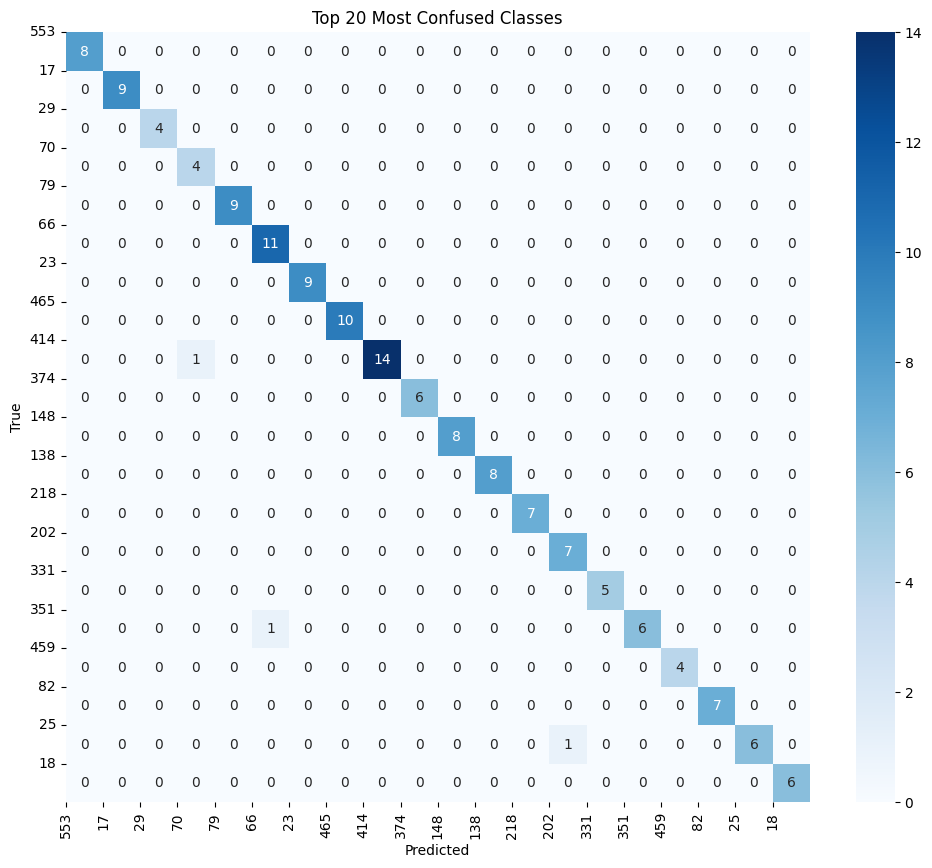

In [ ]:

misclassified = np.sum(cm, axis=1) - np.diag(cm)

top_n = 20
top_indices = np.argsort(misclassified)[-top_n:]

cm_top = cm[top_indices][:, top_indices]

plt.figure(figsize=(12, 10))
sns.heatmap(cm_top, annot=True, fmt='d', cmap='Blues')
plt.title(f"Top {top_n} Most Confused Classes")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(ticks=np.arange(top_n), labels=top_indices, rotation=90)
plt.yticks(ticks=np.arange(top_n), labels=top_indices, rotation=0)
plt.show()


Grad-Cam

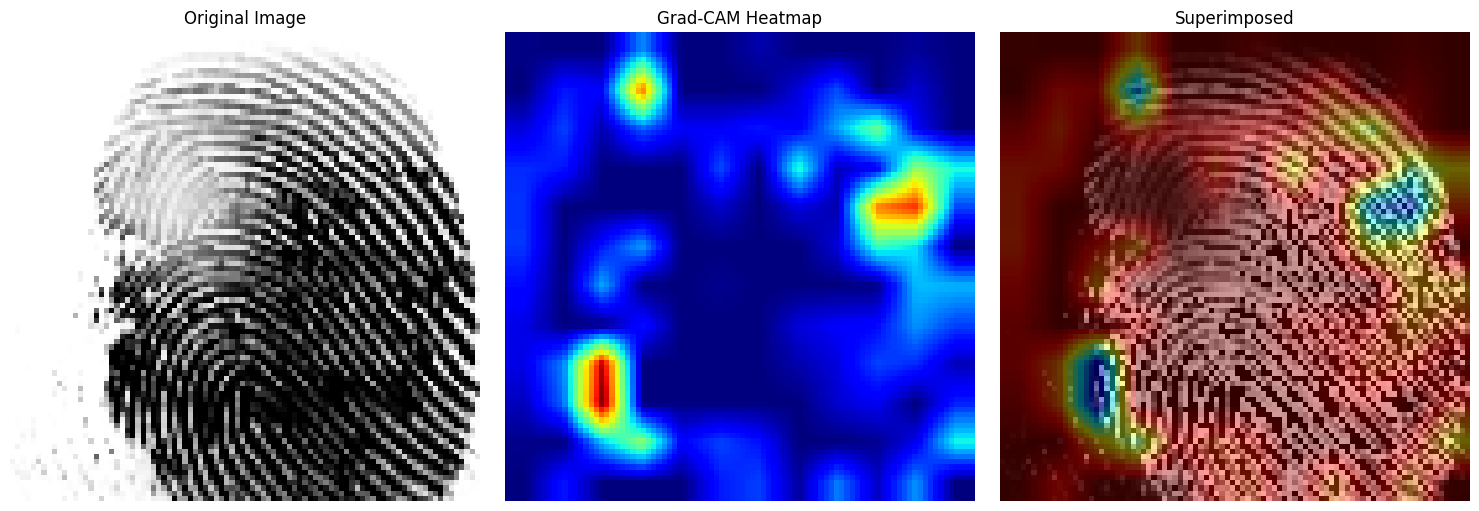

True label: 522
Predicted class: 522
Confidence: 1.00


In [ ]:
import torch
import torch.nn as nn
from torchvision.models import efficientnet_b4, EfficientNet_B4_Weights
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torchvision.transforms as transforms
import torchvision.transforms.functional as F



# 2. Define Grad-CAM wrapper
class EfficientNetB4WithGradCAM(nn.Module):
    def __init__(self, original_model):
        super().__init__()
        self.model = original_model
        self.gradient = None
        self.activations = None

        # Hook the last feature block (before classifier)
        self.model.features[-1].register_forward_hook(self.save_activations)
        self.model.features[-1].register_full_backward_hook(self.save_gradient)

    def save_activations(self, module, input, output):
        self.activations = output

    def save_gradient(self, module, grad_input, grad_output):
        self.gradient = grad_output[0]

    def forward(self, x):
        return self.model(x)

    def get_activations_gradient(self):
        return self.gradient

    def get_activations(self):
        return self.activations



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Wrap model
modeleff = EfficientNetB4WithGradCAM(model).to(device)
modeleff.eval()
# 4. Sample input
sample_idx =14
sample_image = x_train[sample_idx]  # Shape (90, 90, 1)
true_label = label_train[sample_idx]

def preprocess_image(img):
    img = F.to_pil_image(img.squeeze())  # from (90, 90, 1)
    img = img.convert('RGB')
    img = pre_trans(img).unsqueeze(0).to(device)  # Add batch dimension
    return img

input_tensor = preprocess_image(sample_image)

# 5. Forward and backward pass
output = modeleff(input_tensor)
predicted_class = output.argmax(dim=1).item()

modeleff.zero_grad()
one_hot = torch.zeros_like(output).to(device)
one_hot[0][predicted_class] = 1
output.backward(gradient=one_hot, retain_graph=True)

# 6. Get Grad-CAM heatmap
gradients = modeleff.get_activations_gradient()
activations = modeleff.get_activations()

if gradients is not None:
    pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])
else:
    pooled_gradients = torch.mean(activations, dim=[0, 2, 3])  # fallback

for i in range(activations.shape[1]):
    activations[:, i, :, :] *= pooled_gradients[i]

heatmap = torch.mean(activations, dim=1).squeeze().detach().cpu().numpy()
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap) + 1e-8  # Avoid division by zero
heatmap = cv2.resize(heatmap, (sample_image.shape[1], sample_image.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

# 7. Prepare original image
original_img = cv2.cvtColor((sample_image.squeeze() * 255).astype(np.uint8), cv2.COLOR_GRAY2RGB)
superimposed_img = heatmap_color * 0.4 + original_img * 0.6
superimposed_img = np.clip(superimposed_img, 0, 255).astype(np.uint8)

# 8. Plot results
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(sample_image.squeeze(), cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("Grad-CAM Heatmap")
plt.imshow(heatmap, cmap='jet')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("Superimposed")
plt.imshow(superimposed_img)
plt.axis('off')
plt.tight_layout()
plt.show()

# 9. Print prediction
print(f"True label: {true_label}")
print(f"Predicted class: {predicted_class}")
print(f"Confidence: {torch.softmax(output, dim=1)[0][predicted_class].item():.2f}")

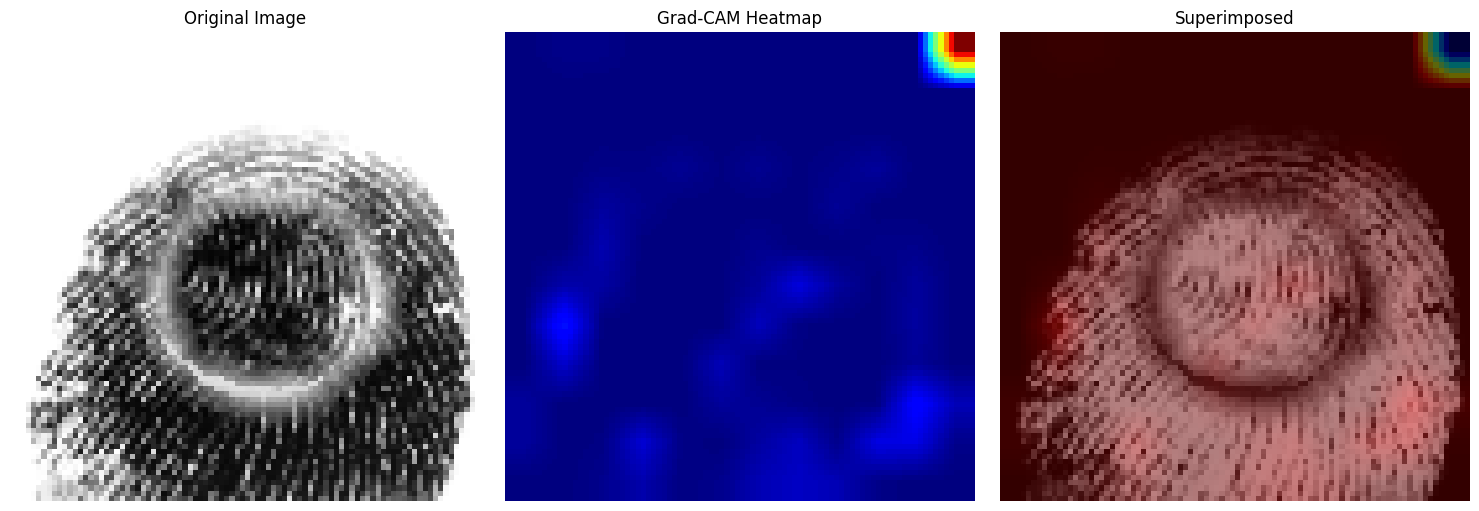

True label: 404
Predicted class: 404
Confidence: 1.00


In [ ]:
import torch
import torch.nn as nn
from torchvision.models import efficientnet_b4, EfficientNet_B4_Weights
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torchvision.transforms.functional as F

# Define the Grad-CAM ready EfficientNet-B4 model
class EfficientNetB4WithGradCAM(nn.Module):
    def __init__(self, original_model):
        super().__init__()
        self.model = original_model
        self.gradient = None
        self.activations = None

        # Hook the last feature block (before classifier)
        self.model.features[-1].register_forward_hook(self.save_activations)
        self.model.features[-1].register_full_backward_hook(self.save_gradient)

    def save_activations(self, module, input, output):
        self.activations = output

    def save_gradient(self, module, grad_input, grad_output):
        self.gradient = grad_output[0]

    def forward(self, x):
        return self.model(x)

    def get_activations_gradient(self):
        return self.gradient

    def get_activations(self):
        return self.activations

# Initialize with YOUR trained model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
modeleff = EfficientNetB4WithGradCAM(model).to(device)
modeleff.eval()

# Load a sample image from your dataset
sample_idx = 0  # Change this to visualize different images
sample_image = x_train[sample_idx] # Shape (90, 90, 1)
true_label = label_train[sample_idx]

# Preprocess the image (matching your dataset preprocessing)
def preprocess_image(img):
    img = F.to_pil_image(img.squeeze())
    img = img.convert('RGB')
    img = pre_trans(img).unsqueeze(0).to(device) # Add batch dimension
    return img

input_tensor = preprocess_image(sample_image)

# Forward pass
output = modeleff(input_tensor)
predicted_class = output.argmax(dim=1).item()

# Backward pass for Grad-CAM
modeleff.zero_grad()
one_hot = torch.zeros_like(output).to(device)
one_hot[0][predicted_class] = 1
output.backward(gradient=one_hot, retain_graph=True)

# Get the gradients and activations
gradients = modeleff.get_activations_gradient()
activations = modeleff.get_activations()

# Pool the gradients across the channels
if gradients is not None:
    pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])
else:
    # Fallback: Use activations as a proxy for gradients if gradients is None
    pooled_gradients = torch.mean(activations, dim=[0, 2, 3])

# Weight the channels by corresponding gradients
for i in range(activations.shape[1]):
    activations[:, i, :, :] *= pooled_gradients[i]

# Average the channels of the activations
heatmap = torch.mean(activations, dim=1).squeeze().detach().cpu().numpy()

# Apply ReLU
heatmap = np.maximum(heatmap, 0)

# Normalize the heatmap
heatmap /= np.max(heatmap) + 1e-8  # Avoid division by zero

# Resize heatmap to match original image size
heatmap = cv2.resize(heatmap, (sample_image.shape[1], sample_image.shape[0]))

# Convert to uint8 and apply colormap
heatmap_color = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)

# Convert original image to RGB for display
original_img = cv2.cvtColor((sample_image.squeeze() * 255).astype(np.uint8), cv2.COLOR_GRAY2RGB)

# Superimpose the heatmap on original image
superimposed_img = heatmap_color * 0.4 + original_img * 0.6
superimposed_img = np.clip(superimposed_img, 0, 255).astype(np.uint8)

# Display results
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(sample_image.squeeze(), cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("Grad-CAM Heatmap")
plt.imshow(heatmap, cmap='jet')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("Superimposed")
plt.imshow(superimposed_img)
plt.axis('off')

plt.tight_layout()
plt.show()

# Print prediction info
print(f"True label: {true_label}")
print(f"Predicted class: {predicted_class}")
print(f"Confidence: {torch.softmax(output, dim=1)[0][predicted_class].item():.2f}")

# SHAP

In [ ]:
def get_correctly_classified_image(loader):
    """Parcourt le loader une fois et retourne la première image bien classée"""
    for images, labels in loader:
        # Transfert sur le bon device
        images, labels = images.to(device), labels.to(device)

        # Prédiction
        with torch.no_grad():
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

        # Cherche la première image correctement classée
        for i in range(len(labels)):
            if preds[i] == labels[i]:
                X_test = images[i:i+1]  # Shape [1, C, H, W]
                y_true = labels[i].item()
                y_pred = preds[i].item()
                print(f"Image trouvée - Classe réelle: {y_true}, Prédite: {y_pred}")
                return X_test, y_true, y_pred

    raise ValueError("Aucune image correctement classée trouvée dans ce batch")

In [ ]:
import shap

# === Paramètres ===
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
mean = [0.485, 0.456, 0.406]
std  = [0.229, 0.224, 0.225]

# === Modèle VGG ===
vgg.eval()

# === 1. Extraire des images de fond ===
def get_background_from_loader(loader, n_samples=20):
    X_background_list = []
    total = 0
    for images, _ in loader:
        X_background_list.append(images)
        total += images.size(0)
        if total >= n_samples:
            break
    X_background = torch.cat(X_background_list, dim=0)[:n_samples]
    return X_background

X_background = get_background_from_loader(train_loader, n_samples=20)

# === 2. Sélectionner une image à expliquer ===
X_test, true_class, pred_class = get_correctly_classified_image(train_loader)

# === 3. Définir l'explainer ===
explainer = shap.GradientExplainer(vgg, X_background)

# === 4. Calcul des SHAP values ===
shap_values, indexes = explainer.shap_values(X_test, ranked_outputs=2)

# === 5. Dénormalisation pour affichage ===
def denormalize_batch(batch, mean, std):
    mean = torch.tensor(mean).view(1, 3, 1, 1).to(batch.device)
    std = torch.tensor(std).view(1, 3, 1, 1).to(batch.device)
    return batch * std + mean

In [ ]:
indexes